In [1]:
import m2aia as m2
import numpy as np
import umap
import os
from sklearn import cluster
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sea
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import stats, signal, interpolate

from SimCLR.code.models import CLR, ContrastiveLoss


/home/jcordes/pym2aia-examples/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-09 17:07:32.361978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 17:07:32.470111: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 17:07:32.499797: E tensorflow/stream_executor/cuda/cuda_blas.cc:

In [2]:

# figures
max_dim = 0
img_size = 124
# target_path = "/home/jtfc/HS/M2aiaPy"
cols = 15
# clustering
n_clusters = 10
n_neighbors = 10
# training
epochs = 50
batch_size = 64

#===================================
# 1. Load image handles
#===================================
# data handling
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])
image_handles = []
for f in file_names[2:3]:
    I = m2.ImzMLReader(f)
    I.SetPooling(m2.m2PoolingMaximum)
    I.SetNormalization(m2.m2NormalizationTIC)
    I.SetBaselineCorrection(m2.m2BaselineCorrectionMedian, 50)
    I.Execute()
    image_handles.append(I)
    print(I.GetShape())
max_dim = np.max([np.max(I.GetShape()[:2]),max_dim])
print("MaximumDimension", max_dim)

#===================================
# 1.1 Pick peaks
#===================================
mean = I.GetMeanSpectrum()
min_indices = signal.argrelmin(mean,order=50)[0]
xs = I.GetXAxis()
peaks = find_peaks(mean, height=np.median(mean)*3.5)
centroids = xs[peaks[0]].tolist()
print("Number of centroids", len(centroids))

#===================================
# 1.2 Initialize the ion image Dataset
#===================================
trans = transforms.Compose([transforms.Lambda(lambda x : torch.Tensor(np.clip(x / np.quantile(x,0.999),0,1))),
                            transforms.CenterCrop(max_dim),
                            transforms.Resize(img_size)])
dataset = m2.IonImageDataset(image_handles, 
                            centroids=centroids, 
                            tolerance=75, 
                            tolerance_type='ppm', 
                            buffer_type='memory', 
                            transforms=trans)

#===================================
# 1.3 Initialize the augmented ion image 
# Dataset which is used during training
#===================================

# adaptions to gaussian noise to work on single channeled images
def gaussian_noise(pix, mean=0, sigmas=(0.001, 0.2)):
    sigma = np.random.uniform(sigmas[0], sigmas[1])   # randomize magnitude
    pix = pix * 255
    # adaptively tune the magnitude, hardcode according to the data distribution. every img is [0, 255]
    if pix[pix > 25].shape[0] > 0:       # 1st thre 25
        aver = torch.mean(pix[pix > 25])
    elif pix[pix > 20].shape[0] > 0:     # 2nd thre 20
        aver = torch.mean(pix[pix > 20])
    elif pix[pix > 15].shape[0] > 0:     # 3nd thre 15
        aver = torch.mean(pix[pix > 15])
    elif pix[pix > 10].shape[0] > 0:     # 4nd thre 10
        aver = torch.mean(pix[pix > 10])
    else:
        aver = torch.mean(pix)
        
    sigma_adp = sigma/153*aver           # 153, 0 homogeneous img average pixel intensity

    # scale gray img to [0, 1]
    pix = pix / 255
    # generate gaussian noise
    noise = np.random.normal(mean, sigma_adp, pix.shape)
    # generate image with gaussian noise
    pix_out = pix + torch.tensor(noise)
    pix_out = np.clip(pix_out, 0, 1)
    img_out = pix_out # convert to PIL image
    return torch.as_tensor(img_out, dtype=torch.float32)

# Dataset returns two augmentations of the same ion image Dataset entry
class AugmentedDataset(Dataset):
  def __init__(self, dataset: m2.Dataset, transform_f):
    super().__init__()
    self.dataset = dataset
    self.transform_f = transform_f

  def __len__(self):
    return self.dataset.__len__()

  def __getitem__(self, index):
    I = self.dataset[index]
    X = self.transform_f(I)
    Y = self.transform_f(I)
    return X, Y

blur_kernel_size = 9
augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
                                    transforms.GaussianBlur(blur_kernel_size, sigma=(0.01, 0.75)), 
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), 
                                    transforms.Lambda(gaussian_noise)])
aug_dataset = AugmentedDataset(dataset, augmentations)


[Wed Nov  9 17:07:35 2022 
21.180] [imzML]: 150505_ew_section3_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 224x169
	[image dims]: 5600.000000x4225.000000
[224 169   1]
MaximumDimension 224
Number of centroids 393


In [3]:
#===================================
# 2 Initializing the SimCLR model
#===================================
m = CLR()
m = m.cuda()
if os.path.exists("SimCLR-Pre.model"):
    state_dict = torch.load("SimCLR-Pre.model")
    m.load_state_dict(state_dict)
else:
    torch.save(m.state_dict(), "SimCLR-Pre.model")


Loaded pretrained weights for efficientnet-b0


In [4]:
#===================================
# 2.1 Predict embeddings of the images
# using the pre-finetuned model
#===================================

m.eval()
A = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if A is None:
        A = embedding
    else:
        A = np.concatenate([A, embedding])




/tmp/ipykernel_3436882/1770824184.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


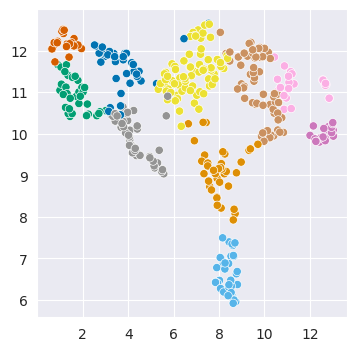

In [5]:
#===================================
# 2.2 Cluster the results using SpectralCustering
#===================================
predictor =  cluster.SpectralClustering(random_state=42,
                                   n_clusters=n_clusters, 
                                   n_neighbors = n_neighbors,
                                   affinity = 'nearest_neighbors', 
                                   assign_labels='discretize')
clusteredA = predictor.fit_predict(A)

#===================================
# 2.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedA = transformer.fit_transform(A)

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
fig = sea.scatterplot(x=transformedA[:,0], y=transformedA[:,1],hue=clusteredA, legend=False, palette="colorblind")


# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [6]:
#===================================
# 3 Load trained model parameters
#===================================
if os.path.exists("SimCLR.model"):
    state_dict = torch.load("SimCLR.model")
    m.load_state_dict(state_dict)
else:
#===================================
# 3 Start finetuning and save model
#===================================

    loss = ContrastiveLoss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())
    scheduler = CosineAnnealingLR(optim, epochs)

    dataloader = DataLoader(aug_dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(aug_dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, [X, Y] in enumerate(dataloader):
            X = X.cuda(non_blocking=True)
            Y = Y.cuda(non_blocking=True)
            _, proj_X = m(X)
            _, proj_Y = m(Y)
            loss_value = loss(proj_X, proj_Y)
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))
    
    torch.save(m.state_dict(), "SimCLR.model")

/tmp/ipykernel_3436882/2123092735.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),


epoch 0 loss: 4.5085129737854
epoch 1 loss: 3.940880060195923
epoch 2 loss: 3.658482551574707
epoch 3 loss: 3.557682752609253
epoch 4 loss: 3.4927730560302734
epoch 5 loss: 3.4028337001800537
epoch 6 loss: 3.3739404678344727
epoch 7 loss: 3.319485902786255
epoch 8 loss: 3.299690008163452
epoch 9 loss: 3.266929864883423
epoch 10 loss: 3.2521040439605713
epoch 11 loss: 3.225572347640991
epoch 12 loss: 3.2071235179901123
epoch 13 loss: 3.1989309787750244
epoch 14 loss: 3.1797704696655273
epoch 15 loss: 3.181208848953247
epoch 16 loss: 3.1490318775177
epoch 17 loss: 3.1509006023406982
epoch 18 loss: 3.1239817142486572
epoch 19 loss: 3.1303012371063232
epoch 20 loss: 3.130575180053711
epoch 21 loss: 3.128657579421997
epoch 22 loss: 3.1123502254486084
epoch 23 loss: 3.1062419414520264
epoch 24 loss: 3.1008994579315186
epoch 25 loss: 3.094059705734253
epoch 26 loss: 3.1001579761505127
epoch 27 loss: 3.0850613117218018
epoch 28 loss: 3.0804214477539062
epoch 29 loss: 3.0752956867218018
epoch 3

In [7]:
#===================================
# 3.1 Predict embeddings of the images
# using the finetuned model
#===================================

m.eval()
hatA = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if hatA is None:
        hatA = embedding
    else:
        hatA = np.concatenate([hatA, embedding])

/tmp/ipykernel_3436882/186080792.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


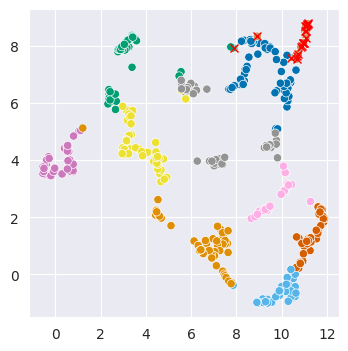

In [8]:
#===================================
# 3.2 Cluster the results using SpectralCustering
#===================================
predictor = cluster.SpectralClustering(random_state=42,
                                n_clusters=n_clusters, 
                                n_neighbors = n_neighbors,
                                affinity = 'nearest_neighbors', 
                                assign_labels='discretize')
clusteredHatA = predictor.fit_predict(hatA)

#===================================
# 3.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedHatA = transformer.fit_transform(hatA)

targetCluster = 5

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
import pandas as pd
# data = pd.DataFrame(np.concatenate([r, c[...,None]],axis=1))

fig = sea.scatterplot(x=transformedHatA[:,0], y=transformedHatA[:,1], hue=clusteredHatA ,legend=False, palette='colorblind')
plt.plot(transformedHatA[:,0][clusteredHatA == targetCluster], transformedHatA[:,1][clusteredHatA == targetCluster], 'rx')


# plt.title("B", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS83_post.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.png", dpi=350)

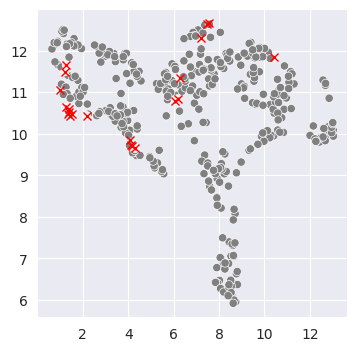

In [9]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
# r_0 = t.transform(dt_0)
# c_0 = km_0.fit_predict(r_0)

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
d = sea.color_palette("light:grey", as_cmap=True)
markedClusters = clusteredHatA
markedClusters[markedClusters!=targetCluster] = 250
fig = sea.scatterplot(x=transformedA[:,0], y=transformedA[:,1], hue=markedClusters, legend=False, palette=d)
plt.plot(transformedA[:,0][clusteredHatA == targetCluster], transformedA[:,1][clusteredHatA == targetCluster], 'rx')
# plt.plot(r_0[:,0][c == 2], r_0[:,1][c == 2], 'or')
# plt.title("A", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

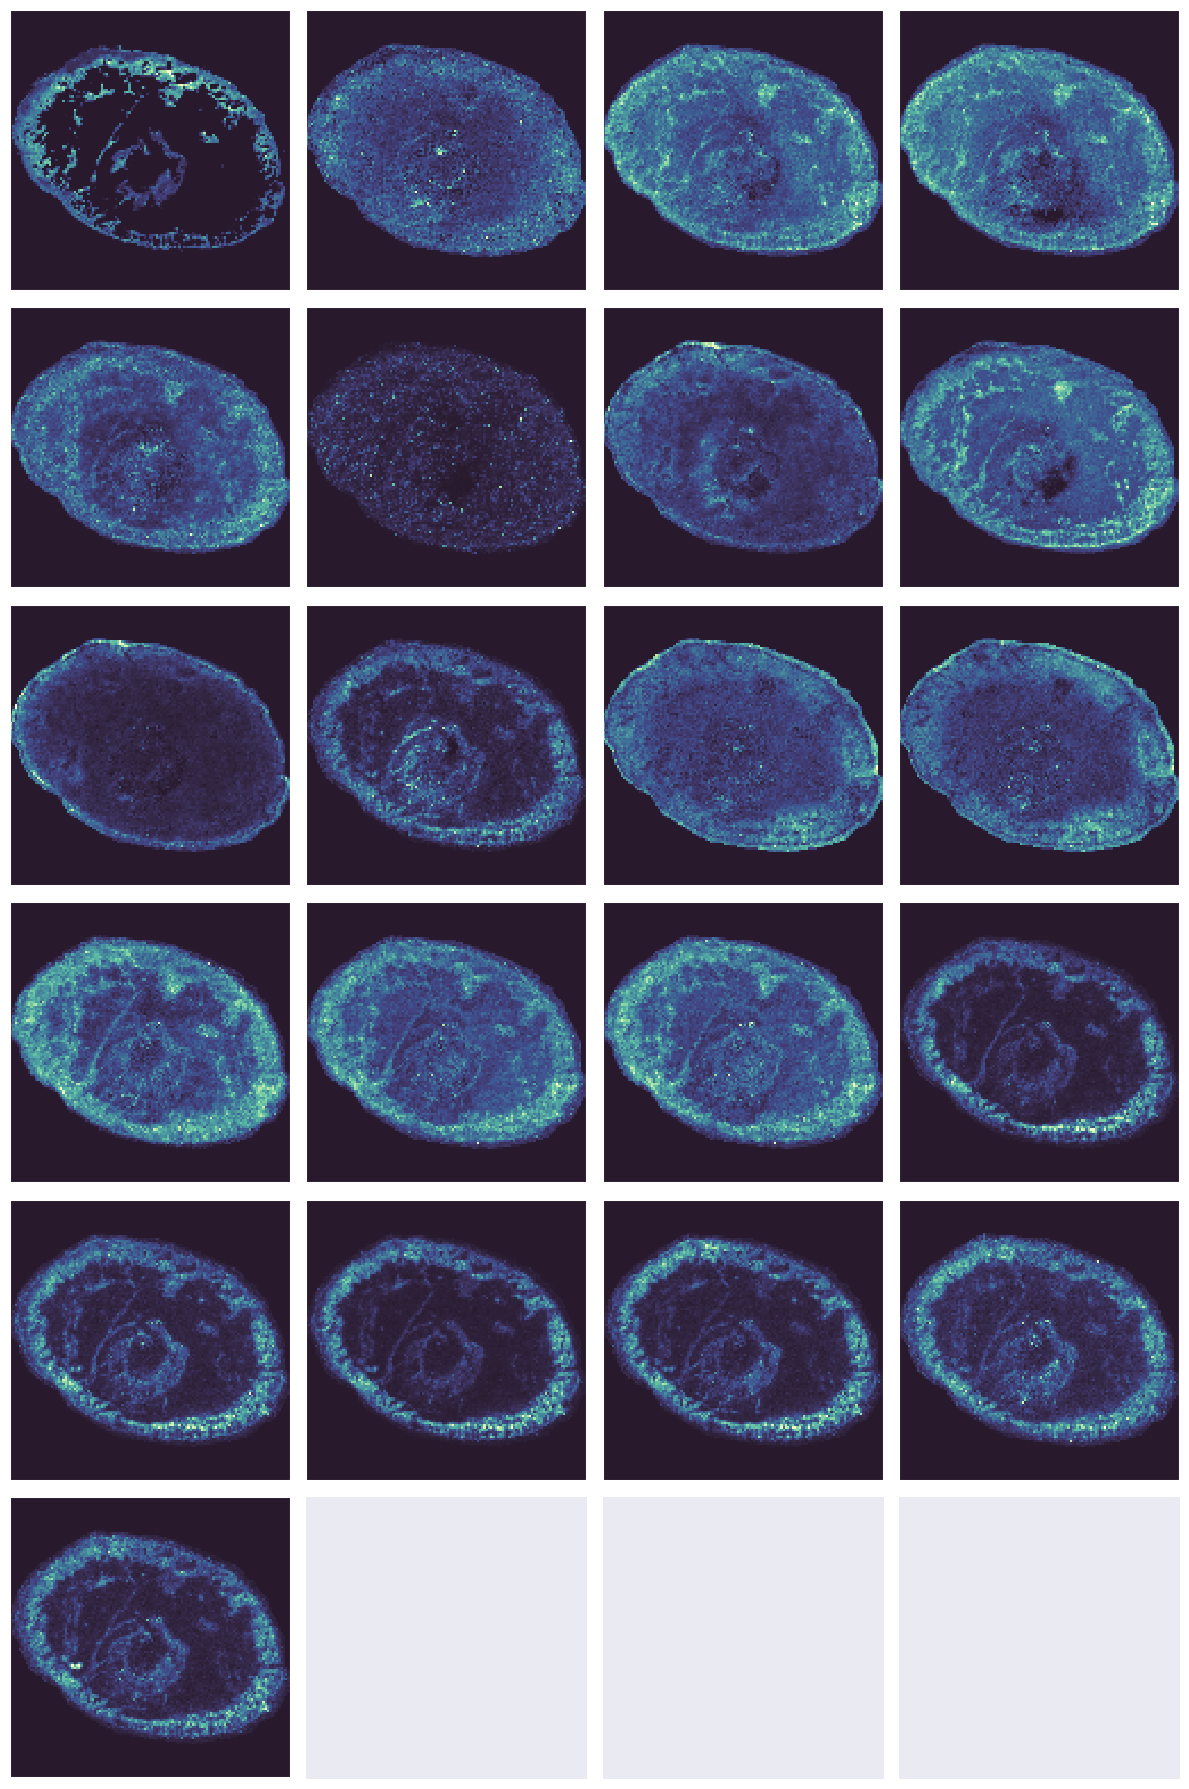

In [19]:
import seaborn_image as isns

ids = np.argwhere(clusteredHatA == targetCluster).flatten().tolist()
images=[]
for id in ids:
    images.append(dataset[id][0])

isns.ImageGrid(images, cbar=False, col_wrap=4)
# plt.savefig(f"{target_path}/FigS8Cluster.png", dpi=350)